In [1]:
# This product uses the FRED® API but is not endorsed or certified by the Federal Reserve Bank of St. Louis
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
from datetime import *
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from fredapi import Fred
fred = Fred(api_key='insert API key')
# API key needs to be requested on the FRED data base
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in data
GDP = pd.DataFrame(fred.get_series_latest_release('GDP')).reset_index()
unemployment_rate = pd.DataFrame(fred.get_series_latest_release('UNRATE')).reset_index()
mortgage_rate = pd.DataFrame(fred.get_series_latest_release('MORTGAGE30US')).reset_index()
CPI = pd.DataFrame(fred.get_series_latest_release('CPIAUCSL')).reset_index()
Tbill_year = pd.DataFrame(fred.get_series_latest_release('DTB1YR')).reset_index()
HPI = pd.DataFrame(fred.get_series_latest_release('USSTHPI')).reset_index()
ic = pd.DataFrame(fred.get_series_latest_release('ICSA')).reset_index()
disp_inc = pd.DataFrame(fred.get_series_latest_release('A229RX0')).reset_index()
consumer_con = pd.DataFrame(fred.get_series_latest_release('CSCICP03USM665S')).reset_index()
business_con = pd.DataFrame(fred.get_series_latest_release('BSCICP03USM665S')).reset_index()

macro_indicators = [GDP, unemployment_rate, mortgage_rate, CPI, Tbill_year, 
                    HPI, ic, disp_inc, consumer_con, business_con]

In [3]:
# index to time and use standardize using datetime
def fix_db(db):
    db.columns = ("Time", "indicator")
    db["Time"] = pd.to_datetime(db["Time"],format='%Y-%m-%d')
    
for ind in macro_indicators:
    fix_db(ind)
    
#alter individual dataframes    
GDP["GDP_growth_rate"]=GDP["indicator"].pct_change()*100
GDP.drop(["indicator"], axis = 1, inplace = True)  

# merge dataframs across time
indicators_merged = reduce(lambda left,right: pd.merge(left,right,on=['Time'],
                                              how='outer'), macro_indicators);
indicators_merged.columns = ("YYYY-MM-DD", "GDP_growth_rate", "unemployment_rate", "mortgage_rate", 
                             "CPI", "treasury_bill_rate_yr", "HPI", "inital_claims(weekly)", 
                             "disposeable_income", "consumer_confidence", "business_confidence");
indicators_merged = indicators_merged[indicators_merged["YYYY-MM-DD"] >= datetime(2019, 1, 1)]
indicators_merged = indicators_merged.sort_values("YYYY-MM-DD", 
                                                  ascending = True).reset_index().drop("index", axis = 1)


#create all dates column and merge
date_range = pd.DataFrame(pd.to_datetime(pd.date_range(start = indicators_merged["YYYY-MM-DD"].iloc[0], 
                                                       end = indicators_merged["YYYY-MM-DD"].iloc[-1], 
                                                       freq='D'),format='%Y-%m-%d'))
date_range.columns = ["YYYY-MM-DD"]
indicators = pd.merge(date_range, indicators_merged, on=["YYYY-MM-DD"], how='outer')

In [4]:
target = pd.read_excel('/Users/risshail/Downloads/Target_Variable_Risshail.xlsx',sheet_name='Sheet1')
target["YYYY-MM-DD"] = pd.to_datetime(pd.date_range(end = "2022-07-12", 
                                                    periods=len(target), freq='W'),format='%Y-%m-%d')
target.drop("Week#", axis = 1, inplace = True)
target.columns = ["Target", "YYYY-MM-DD"]
target = target[["YYYY-MM-DD", "Target"]]

## Weekly Data

In [5]:
weekly = indicators.ffill().groupby([[i//7 for i in range(0, len(indicators))]], 
                                      axis = 0).mean()

weekly_date_range = pd.period_range(start = indicators["YYYY-MM-DD"].iloc[0], 
                                    end = indicators["YYYY-MM-DD"].iloc[-1], freq = 'W-SAT')
weekly_date_range = weekly_date_range.map(str)
weekly_date_range = weekly_date_range.str.split('/').str[0]
weekly_date_range = pd.Series(weekly_date_range)

weekly["YYYY-MM-DD"] = pd.to_datetime(weekly_date_range)

df = pd.merge(target, weekly,  on = ["YYYY-MM-DD"], how = "outer")
df = df.sort_values("YYYY-MM-DD", ascending = True).reset_index().drop("index", axis = 1)
df = df[df["Target"].isnull() == False].reset_index().drop(["index"], axis = 1)

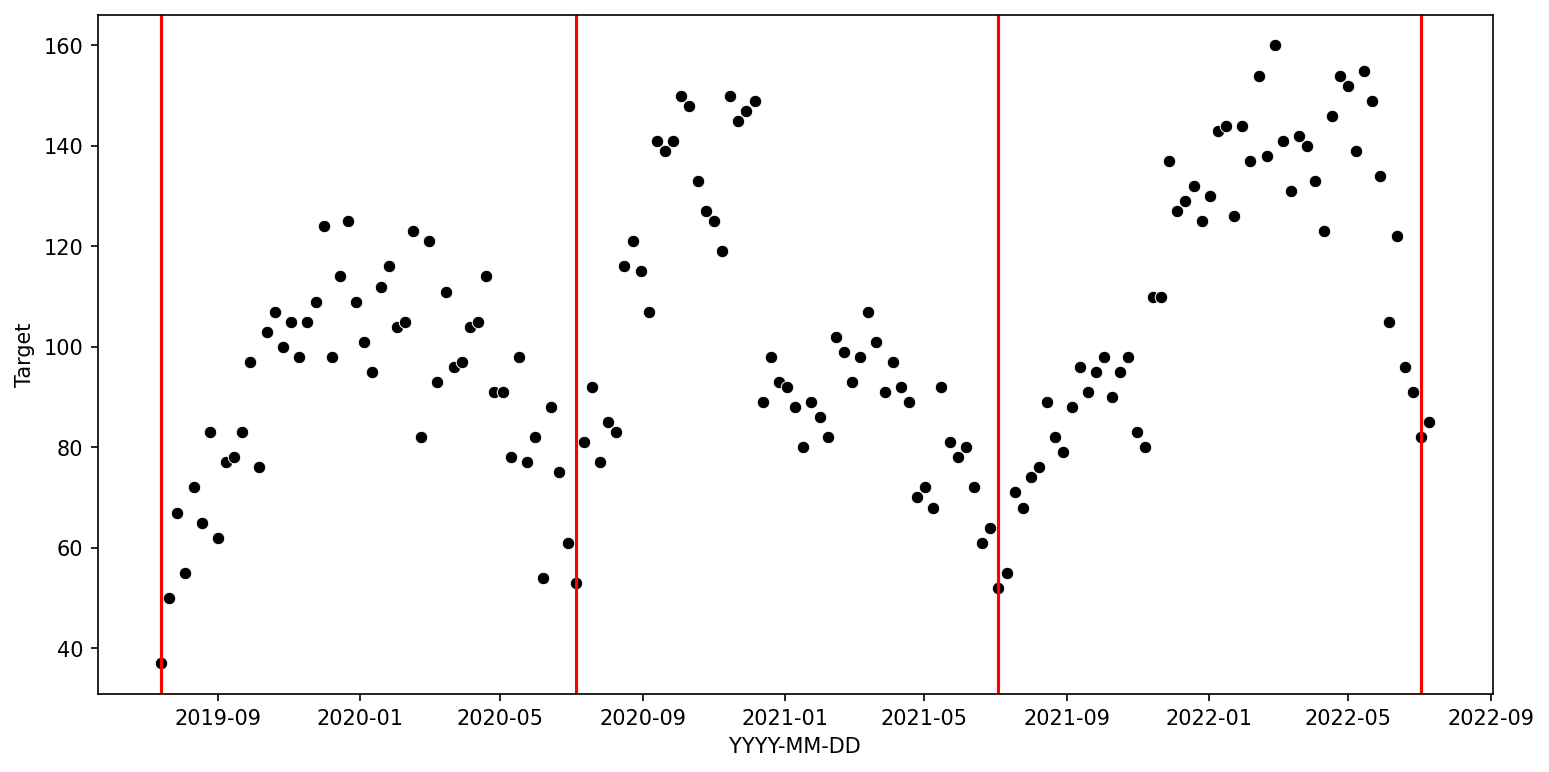

In [41]:
plt.figure(figsize=(12,6),dpi=150)
sns.scatterplot(x='YYYY-MM-DD',y='Target',data=df,color='black')
plt.axvline(x = pd.to_datetime("2019-07-14"), color = "red")
plt.axvline(x = pd.to_datetime("2020-07-05"), color = "red")
plt.axvline(x = pd.to_datetime("2021-07-04"), color = "red")
plt.axvline(x = pd.to_datetime("2022-07-03"), color = "red");

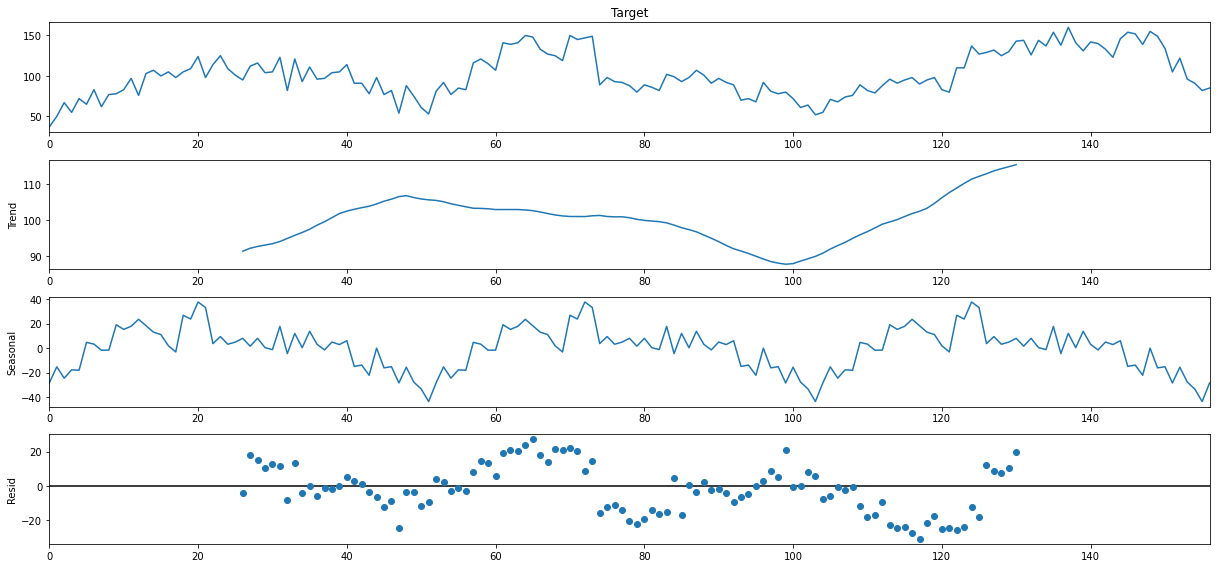

In [42]:
plt.rcParams['figure.figsize'] = (17,8)
decomposition = sm.tsa.seasonal_decompose(df['Target'], model='additive', period = 52)
fig = decomposition.plot()
plt.show()

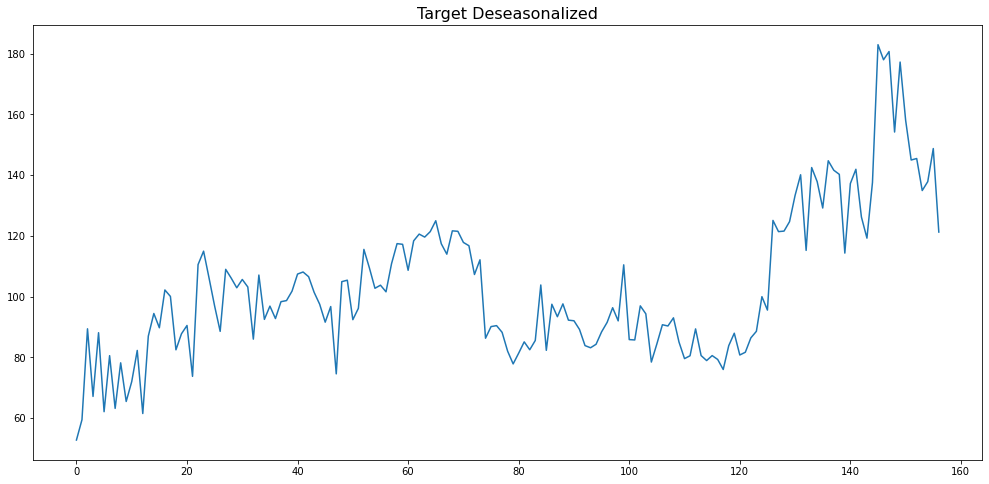

In [43]:
result_mul = seasonal_decompose(df['Target'], model='multiplicative', period=52)
deseasonalized = df['Target'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Target Deseasonalized', fontsize=16)
plt.plot();

In [44]:
desea_df = df
desea_df["deseasonalised_target"] = df['Target'].values / result_mul.seasonal
desea_df.set_index("YYYY-MM-DD", inplace = True)

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = vardf[vardf.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(vardf.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Train Test Split

In [55]:
predictors = df[["Target", "mortgage_rate", "CPI", 
                 "treasury_bill_rate_yr", "consumer_confidence", "business_confidence", "disposeable_income"]]

X = predictors[["mortgage_rate", "CPI", 
                "treasury_bill_rate_yr", "consumer_confidence", 
                "business_confidence", "disposeable_income"]]
Y = predictors[["Target"]]

In [56]:
predictors = df[["Target", "mortgage_rate", "HPI"]]

X = predictors[["mortgage_rate", "HPI"]]
Y = predictors[["Target"]]

In [73]:
train = predictors[:-12].set_index("YYYY-MM-DD")
test = predictors[-12:].set_index("YYYY-MM-DD")

x_train = train.drop(["Target"], axis = 1)
y_train = train[["Target"]]
x_test = test.drop(["Target"], axis = 1)
y_test = test[["Target"]]

# Regression 

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_converter = PolynomialFeatures(degree=3, include_bias=False)
poly_features = polynomial_converter.fit_transform(X)
poly_features.shape

(157, 9)

In [36]:
poly_X_train = poly_features[:-12]
poly_X_test = poly_features[-12:]

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
poly_model = LinearRegression(fit_intercept=False)
poly_model.fit(poly_X_train,y_train)

LinearRegression(fit_intercept=False)

In [38]:
print("Train Accuracy:",poly_model.score(poly_X_train, y_train))
print("Test Accuracy:",poly_model.score(poly_X_test, y_test))

Train Accuracy: 0.5458537668814669
Test Accuracy: 0.21628975542033524


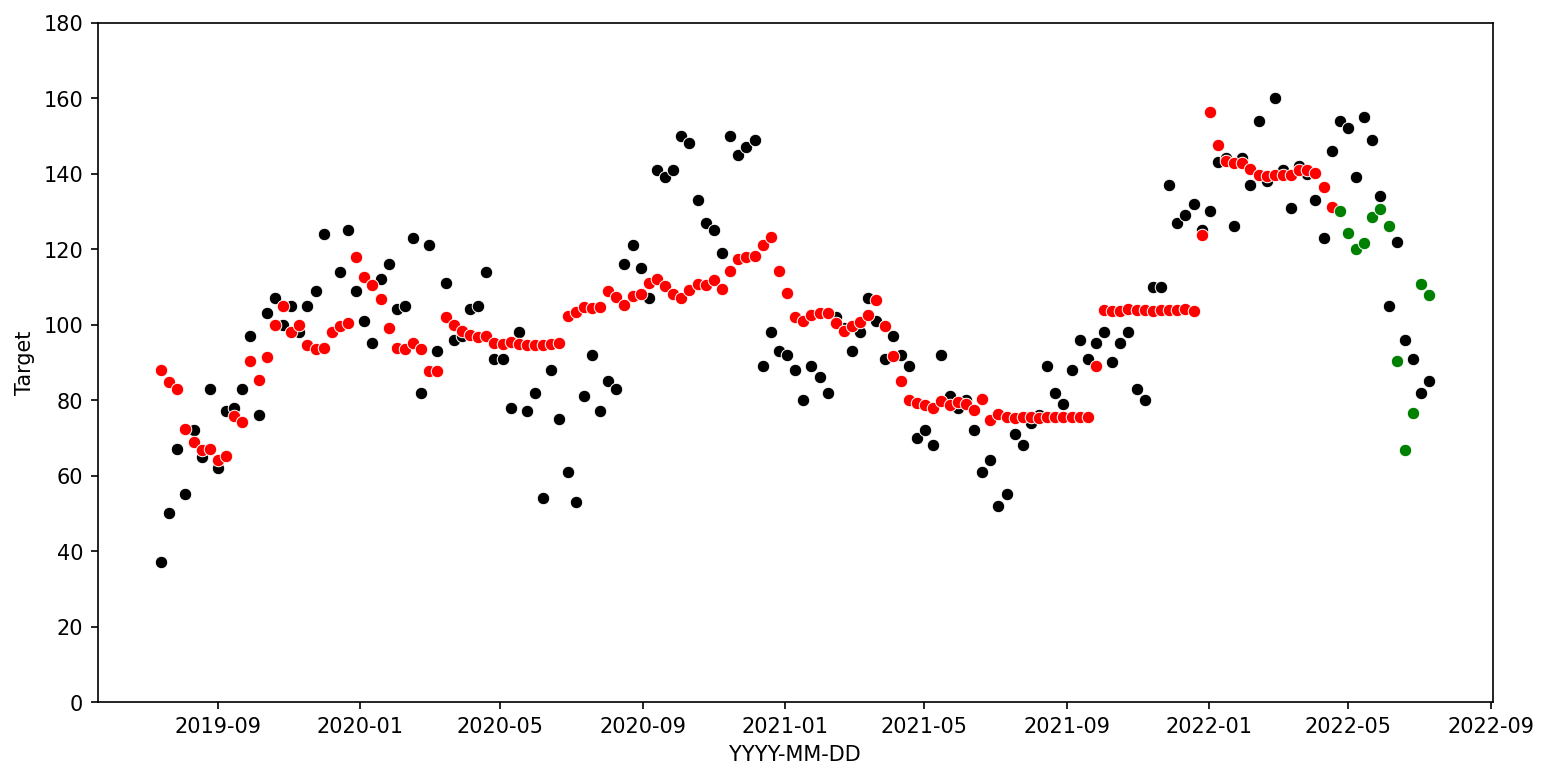

In [39]:
train_preds = poly_model.predict(poly_X_train).reshape(-1,1)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
train_preds = pd.DataFrame(train_preds, columns = ["Predictions"])
train_results = pd.merge(y_train.reset_index(), 
                         train_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

test_preds = poly_model.predict(poly_X_test)
test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
test_preds = pd.DataFrame(test_preds, columns = ["Predictions"])
test_results = pd.merge(y_test.reset_index(), 
                         test_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

plt.figure(figsize=(12,6),dpi=150)
plt.ylim(0, 180)
sns.scatterplot(x='YYYY-MM-DD',y='Target',data=Y,color='black')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=train_results,color='red')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=test_results,color='green');

### Random Forest Deseasonalised

In [57]:
predictors = desea_df[["deseasonalised_target", "mortgage_rate", "HPI"]]

train = predictors[:-12]
test = predictors[-12:]

x_train = train.drop(["deseasonalised_target"], axis = 1)
y_train = train[["deseasonalised_target"]]
x_test = test.drop(["deseasonalised_target"], axis = 1)
y_test = test[["deseasonalised_target"]]

In [58]:
from sklearn.ensemble import RandomForestRegressor

drf_model = RandomForestRegressor(n_estimators=100, random_state = 2)
drf_model.fit(x_train,y_train)
# max_features = 2, max_depth=90, min_samples_leaf=5, min_samples_split=10

print("Train Accuracy:",drf_model.score(x_train, y_train))
print("Test Accuracy:",drf_model.score(x_test, y_test))

Train Accuracy: 0.9388201523295744
Test Accuracy: -1.3846540573444108


In [ ]:
#against training data
train_preds = drf_model.predict(x_train).reshape(-1,1)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
# print(train_rmse)
train_preds = pd.DataFrame(train_preds, columns = ["Predictions"])
train_results = pd.merge(y_train.reset_index(), 
                         train_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

test_preds = drf_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
# print(test_rmse)
test_preds = pd.DataFrame(test_preds, columns = ["Predictions"])
test_results = pd.merge(y_test.reset_index(), 
                         test_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

plt.figure(figsize=(12,6),dpi=150)
plt.ylim(0, 180)
sns.scatterplot(x='YYYY-MM-DD',y='deseasonalised_target',data=desea_df,color='black')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=train_results,color='red');
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=test_results,color='green');

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state = 2)
rf_model.fit(x_train,y_train)
# max_features = 2, max_depth=90, min_samples_leaf=5, min_samples_split=10

print("Train Accuracy:",rf_model.score(x_train, y_train))
print("Test Accuracy:",rf_model.score(x_test, y_test))

Train Accuracy: 0.9476524109470451
Test Accuracy: -0.4088949062844547


In [19]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [61]:
# plot_feature_importance(rf_model.feature_importances_,train.columns,'RANDOM FOREST')

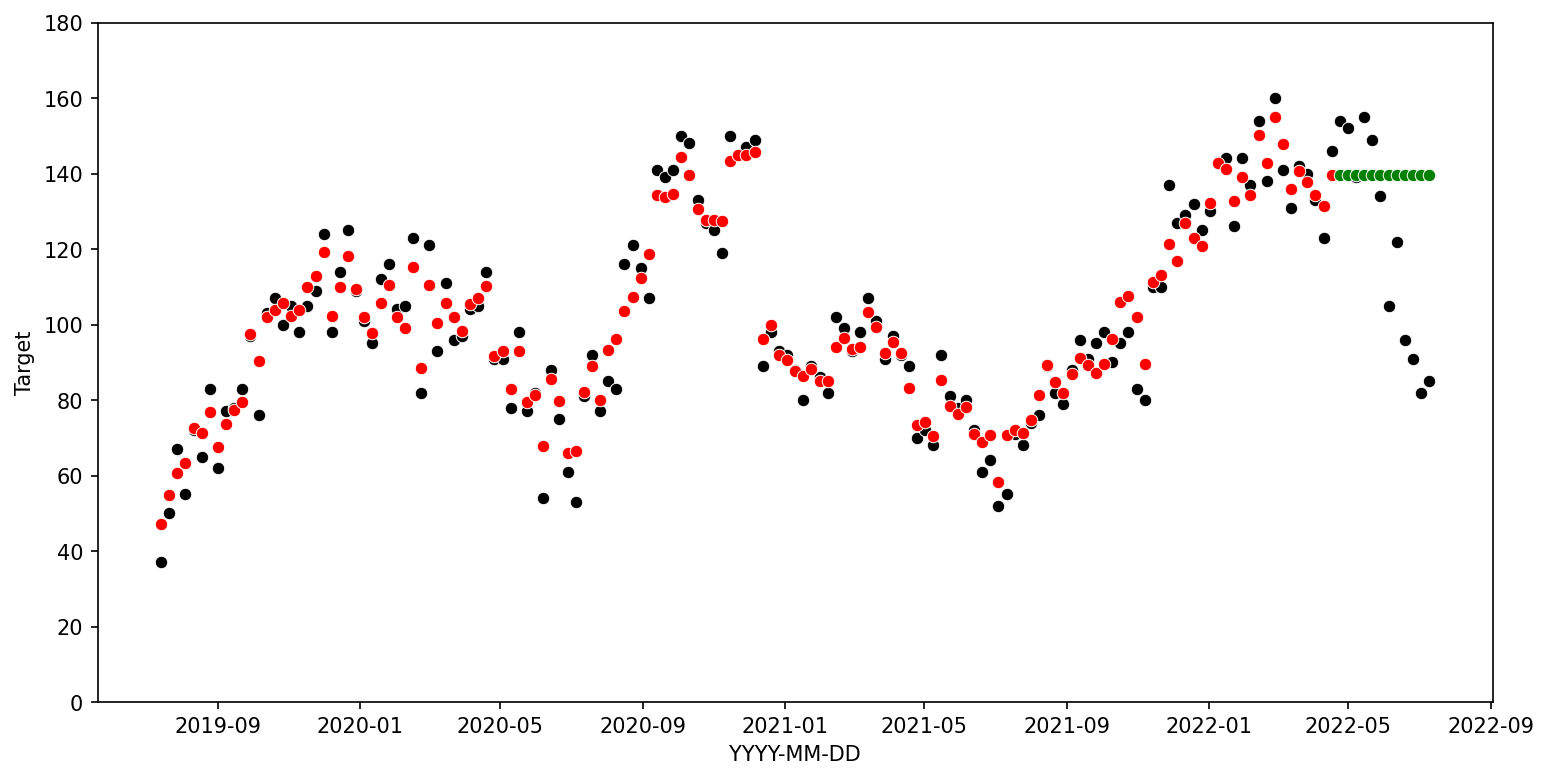

In [20]:
#against training data
train_preds = rf_model.predict(x_train).reshape(-1,1)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
# print(train_rmse)
train_preds = pd.DataFrame(train_preds, columns = ["Predictions"])
train_results = pd.merge(y_train.reset_index(), 
                         train_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

test_preds = rf_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
# print(test_rmse)
test_preds = pd.DataFrame(test_preds, columns = ["Predictions"])
test_results = pd.merge(y_test.reset_index(), 
                         test_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')

plt.figure(figsize=(12,6),dpi=150)
plt.ylim(0, 180)
sns.scatterplot(x='YYYY-MM-DD',y='Target',data=Y,color='black')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=train_results,color='red');
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=test_results,color='green');

In [27]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [29]:
best_grid

RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=5,
                      min_samples_split=10)

### XGBoost Regression

In [146]:
# pip install xgboost

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [22]:
xgbr_model = XGBRegressor(seed = 42)
xgbr_model.fit(x_train, y_train);
print("Train Accuracy:",xgbr_model.score(x_train, y_train))
print("Test Accuracy:",xgbr_model.score(x_test, y_test))

Train Accuracy: 0.9966384061865364
Test Accuracy: -0.7359127018391232


In [23]:
#against training data
train_preds = xgbr_model.predict(x_train).reshape(-1,1)
train_rmse = np.sqrt(mean_squared_error(y_train,train_preds))
# print(train_rmse)
train_preds = pd.DataFrame(train_preds, columns = ["Predictions"])
train_results = pd.merge(y_train.reset_index(), 
                         train_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')
# plt.figure(figsize=(12,6),dpi=150)
# sns.scatterplot(x='YYYY-MM-DD',y='Target',data=train_results,color='black');

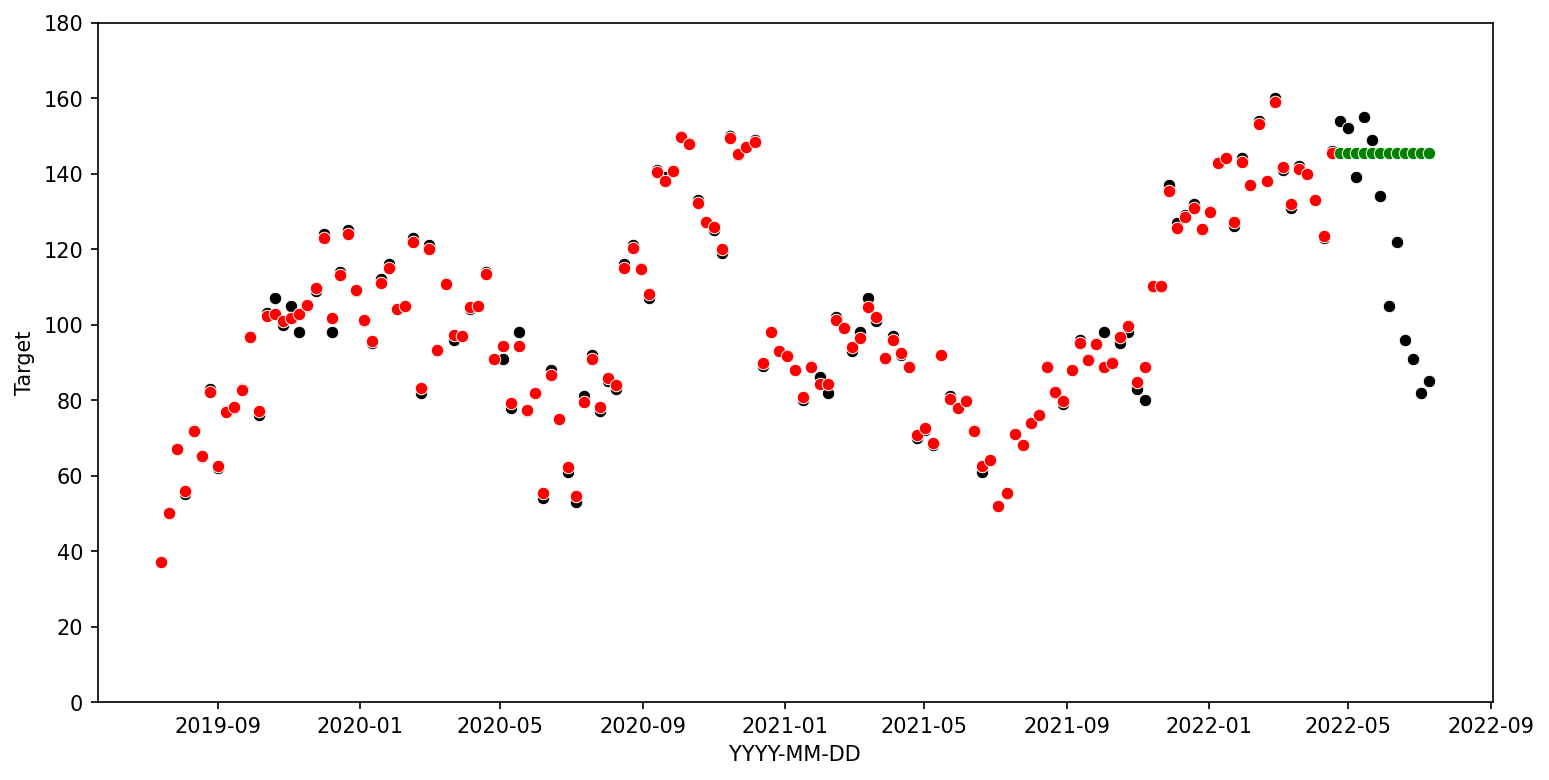

In [24]:
test_preds = xgbr_model.predict(x_test)
test_rmse = np.sqrt(mean_squared_error(y_test,test_preds))
# print(test_rmse)
test_preds = pd.DataFrame(test_preds, columns = ["Predictions"])
test_results = pd.merge(y_test.reset_index(), 
                         test_preds, 
                         left_index=True, 
                         right_index=True).set_index('YYYY-MM-DD')
plt.figure(figsize=(12,6),dpi=150)
plt.ylim(0, 180)
sns.scatterplot(x='YYYY-MM-DD',y='Target',data=Y,color='black')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=train_results,color='red')
sns.scatterplot(x='YYYY-MM-DD',y='Predictions',data=test_results,color='green');

https://github.com/nachi-hebbar/Multivariate-Time-Series-Forecasting/blob/main/VAR_Model%20(1).ipynb

### Vector Auto Regression

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm

In [75]:
vardf = df.set_index("YYYY-MM-DD")

In [76]:
ad_fuller_result_1 = adfuller(vardf['Target'].diff()[1:].diff()[1:])

print('target')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(vardf['mortgage_rate'].diff()[1:].diff()[1:])

print('mortgage')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(vardf['CPI'].diff()[1:].diff()[1:])

print('CPI')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(vardf['consumer_confidence'].diff()[1:].diff()[1:])

print('consumer_confidence')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

target
ADF Statistic: -8.479120531660515
p-value: 1.408778791138541e-13

---------------------

mortgage
ADF Statistic: -4.448053521050899
p-value: 0.00024380163705312922

---------------------

CPI
ADF Statistic: -8.479120531660515
p-value: 1.408778791138541e-13

---------------------

consumer_confidence
ADF Statistic: -4.448053521050899
p-value: 0.00024380163705312922


In [77]:
print('mortgage_rate causes target?')
print('------------------')
granger_1 = grangercausalitytests(vardf[["Target", "mortgage_rate"]], 4)

print('\ntarget causes mortgage rate?')
print('------------------')
granger_1 = grangercausalitytests(vardf[["Target", "mortgage_rate"]], 4)

mortgage_rate causes target?
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0797  , p=0.7781  , df_denom=153, df_num=1
ssr based chi2 test:   chi2=0.0812  , p=0.7756  , df=1
likelihood ratio test: chi2=0.0812  , p=0.7757  , df=1
parameter F test:         F=0.0797  , p=0.7781  , df_denom=153, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4802  , p=0.6196  , df_denom=150, df_num=2
ssr based chi2 test:   chi2=0.9924  , p=0.6088  , df=2
likelihood ratio test: chi2=0.9893  , p=0.6098  , df=2
parameter F test:         F=0.4802  , p=0.6196  , df_denom=150, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3893  , p=0.7609  , df_denom=147, df_num=3
ssr based chi2 test:   chi2=1.2236  , p=0.7474  , df=3
likelihood ratio test: chi2=1.2188  , p=0.7485  , df=3
parameter F test:         F=0.3893  , p=0.7609  , df_denom=147, df_num=3

Granger Causality
number of lags (no zero) 4


* try VAR model with deseasonalised data using mortgage rate
* use a multivariate time-series model
* use differencing on your data to get values below 0.05

In [ ]:
#standardize data

"""
df_indicator = df[["Target", "GDP_growth_rate", "unemployment_rate", "mortgage_rate", "CPI", 
                   "treasury_bill_rate_yr", "HPI", "inital_claims(weekly)", 
                   "disposeable_income", "consumer_confidence", "business_confidence"]]
standardized = df
standardized[["Target", "GDP_growth_rate", "unemployment_rate", "mortgage_rate", "CPI", 
              "treasury_bill_rate_yr", "HPI", "inital_claims(weekly)", 
              "disposeable_income", "consumer_confidence", 
              "business_confidence"]] = (df_indicator - df_indicator.mean())/df_indicator.std()
""";

In [ ]:
"""
#!/usr/bin/env python
# coding: utf-8

# In[2]:


#Importing libraries
import pandas as pd
from sklearn.feature_selection import RFE #to select features by considering smaller sets
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from datetime import timedelta
import calendar
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#Loading the dataset
import os
os.chdir("D:\\Analytics\\Cooper Volume forecast_MA_Exp\\18Jul\\")
df == import data (your file)

# In[3]:


#Trend Analysis for the Volume data from 2019 to 2022

def plot_df(df, x, y, title="", xlabel='Weeks', ylabel='Volumes', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.Volumes, title='Weekly Volumes from 2019 to 2022.')    


# In[4]:


df.head()


# In[5]:


import statsmodels.api as sm


# In[6]:


# Decomposing the Volumes to identify the trend over the period along with seasonal fluctuations and noise
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Volumes'], model='additive')
fig = decomposition.plot()
plt.show()


# In[7]:


df1 = df.drop(columns=['Week No', 'Month No', 'Year'])


# In[8]:


#Plotting the heatmap to show the correlations between Volume and other variables. Higher value shows more correlated variables and vice versa.
import seaborn as sb
dataplot = sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
dataplot


# In[9]:


# scatter plots to understand correlations between indicators 
sb.pairplot(df1, height = 1.8)


# In[10]:


#Dropping columns due to high correlations 
df2 = df1.drop(columns=['GDP','Business Confidence Index','Housing Price Index'])


# In[11]:


#Granger's causality test - It is used to determine whether one time series is useful to forecast another time series

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df1 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df1.columns:
        for r in df1.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df1.loc[r, c] = min_p_value
    df1.columns = [var + '_x' for var in variables]
    df1.index = [var + '_y' for var in variables]
    return df1

grangers_causation_matrix(df2, variables = df2.columns)  


# In[12]:


#Declaring the x and y variables

X = df2.drop(columns = 'Volumes',axis = 1)
y = df2['Volumes']


# In[14]:


# Extract the training and test data

from sklearn.model_selection import train_test_split
data = df2.values
#X = data[:, 1:]  # all rows, no label
#y = data[:, 0]  # all rows, label only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# In[35]:


#importing random forest module
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
model = RandomForestRegressor(n_estimators = 500, random_state = 5)
model.fit(X_train, y_train)

print("Train Accuracy:",model.score(X_train, y_train))
print("Test Accuracy:",model.score(X_test, y_test))
#Training Score and Testing Score
#accuracy_score(y_train,regressor.score(X_train))
#accuracy_score(y_test,regressor.score(X_test))


# In[16]:


#apply the model on train and test, check the train and test accuracy(performance matrix)

y_pred = pd.DataFrame(model.predict(X_test))
y_pred


# In[21]:


y_test


# In[39]:


from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred,y_test )
mse


# In[18]:


from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)

print("MAE=", mae)


# In[ ]:

# #ratio of positive samples correctly classified as positive to the total samples
# print("Test Recall:",metrics.recall_score(y_test, y_pred))
# print("Train Recall:",metrics.recall_score(_train, y_pred))
"""